<a href="https://colab.research.google.com/github/rudyhendrawn/traditional-dance-video-classification/blob/main/i3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rfv sample_data

### Mounting Repository

Mount the repository to get all the data (directories and utilities files) ready to use.

In [11]:
!git clone https://github.com/rudyhendrawn/traditional-dance-video-classification.git
!mv traditional-dance-video-classification/* .
!rm -rfv traditional-dance-video-classification

Cloning into 'traditional-dance-video-classification'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 187 (delta 60), reused 66 (delta 16), pack-reused 47
Receiving objects: 100% (187/187), 127.22 MiB | 31.70 MiB/s, done.
Resolving deltas: 100% (73/73), done.
mv: cannot move 'traditional-dance-video-classification/checkpoint' to './checkpoint': Directory not empty
mv: cannot move 'traditional-dance-video-classification/dataset' to './dataset': Directory not empty
mv: cannot move 'traditional-dance-video-classification/history' to './history': Directory not empty
mv: cannot move 'traditional-dance-video-classification/img' to './img': Directory not empty
mv: cannot move 'traditional-dance-video-classification/lib' to './lib': Directory not empty
mv: cannot move 'traditional-dance-video-classification/misc' to './misc': Directory not empty
mv: cannot move 'traditional-dance-video-c

### Mounting Google Drive

Google drive need to be setup and mounted to this specific project. Using this code below to setup and mount the google drive.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Initial Setup 🧑‍💻

Setup the project, import the required dependencies

> Make sure the `lib` directory exists and include: `keras_video`, `i3d_inception.py`

In [1]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import lib.helpers as helpers

from lib.keras_video import VideoFrameGenerator
from lib.i3d_inception import Inception_Inflated3d

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from IPython import get_ipython

get_ipython().run_line_magic("matplotlib", "inline")
warnings.filterwarnings("ignore")

In [14]:
DS = os.path.sep
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/datasets/Tari-Bali' # Change with the correct path to your dataset

# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile(os.path.join(DATASET_PATH, 'Dasar-Gerakan-Tari-Bali-All-Men.zip'), 'r') as zObject:
    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(path=os.path.join('/content'))



### Generating Class Names & Glob Pattern

Load all the file paths at the DATASET_DIR to generate the class names. Also, define glob pattern to get the dataset

In [3]:
# Read the video from specified path
DATASET_DIR = os.path.join('/content/Dasar-Gerakan-Tari-Bali-All-Men')

class_names = helpers.get_generated_class_names(DATASET_DIR, "train")
print(class_names)
train_glob_pattern = helpers.get_generated_glob_pattern(DATASET_DIR, "train")
test_glob_pattern = helpers.get_generated_glob_pattern(DATASET_DIR, "test");
val_glob_pattern = helpers.get_generated_glob_pattern(DATASET_DIR, "val");

['Agem_Kanan', 'Agem_Kiri', 'Gandang_Gandang', 'Malpal', 'Nayog', 'Nepuk_Kampuh', 'Oyod', 'Piles', 'Seledet', 'Tapak_Sirang_Pada', 'Ulap_Ulap']


### Dataset Setup

Setup the dataset with `keras_video.VideoFrameGenerator` to do the dataset extraction

In [4]:
BATCH_SIZE = 8
NB_COLOR_CHANNELS = 3
NB_FRAMES = 30
RESOLUTION = (224, 224)

train_dataset_generator = VideoFrameGenerator(
    batch_size=BATCH_SIZE,
    classes=class_names,
    glob_pattern=train_glob_pattern,
    nb_channel=NB_COLOR_CHANNELS,
    nb_frames=NB_FRAMES,
    seed=42,
    target_shape=RESOLUTION,
    transformation=None,
    use_frame_cache=False
)

Total data: 11 classes for 531 files for train


In [5]:
test_dataset_generator = VideoFrameGenerator(
    batch_size=BATCH_SIZE,
    classes=class_names,
    glob_pattern=test_glob_pattern,
    nb_channel=NB_COLOR_CHANNELS,
    nb_frames=NB_FRAMES,
    seed=42,
    target_shape=RESOLUTION,
    transformation=None,
    use_frame_cache=False
)

Total data: 11 classes for 165 files for train


In [6]:
val_dataset_generator = VideoFrameGenerator(
    batch_size=BATCH_SIZE,
    classes=class_names,
    glob_pattern=val_glob_pattern,
    nb_channel=NB_COLOR_CHANNELS,
    nb_frames=NB_FRAMES,
    seed=42,
    target_shape=RESOLUTION,
    transformation=None,
    use_frame_cache=False
)

Total data: 11 classes for 132 files for train


In [7]:
for x, y in train_dataset_generator:
    print(f"Data shape in data generator {x.shape}")
    break

for x, y in val_dataset_generator:
    print(f"Data shape in data generator {x.shape}")
    break

for x, y in test_dataset_generator:
    print(f"Data shape in data generator {x.shape}")
    break

Data shape in data generator (8, 30, 224, 224, 3)
Data shape in data generator (8, 30, 224, 224, 3)
Data shape in data generator (8, 30, 224, 224, 3)


In [8]:
input_shape = (NB_FRAMES,) + RESOLUTION + (NB_COLOR_CHANNELS,)
print(input_shape)

(30, 224, 224, 3)


### Prepare `i3d` Layer

Preparing the configuration to create the `i3d` layer to add to the created model

In [9]:
i3d_layer = Inception_Inflated3d(
    classes=3,
    include_top=False,
    input_shape=input_shape,
    weights="rgb_kinetics_only"
)

i3d_layer.trainable = False

### Model Creation

Creating `Sequential` model and add `i3d` and some other layers to the created model

In [10]:
model = tf.keras.models.Sequential()

# classification layer
model.add(i3d_layer)
model.add(tf.keras.layers.GlobalAveragePooling3D())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(int(len(class_names)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 i3d_inception (Functional)  (None, 3, 1, 1, 1024)     12294544  
                                                                 
 global_average_pooling3d (G  (None, 1024)             0         
 lobalAveragePooling3D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 11)                5643      
                                                                 
Total params: 12,824,987
Trainable params: 530,443
Non-trainable params: 12,294,544
______________________________________

### Compiling & Fitting Setup

Some setup configuration for compiling and fitting the model. Defining epochs, earlystopping, checkpoint, and callbacks.

In [11]:
epochs = 100
model_earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoint/i3d-{epoch:02d}-{val_loss:.2f}.h5",
    mode="min",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

model_callbacks = [model_earlystopping, model_checkpoint]

### Model Compile

Compiling model with pre-defined configuration

In [12]:
model.compile(
    loss="categorical_crossentropy",
    metrics=["acc"],
    optimizer="adam"
)

### Model Training/Fitting

Fit the model with real dataset with defined epochs and callbacks

In [13]:
tf.keras.backend.clear_session()

start_time = time.time()

model_history = model.fit(
    train_dataset_generator,
    callbacks=model_callbacks,
    epochs=epochs,
    validation_data=val_dataset_generator
)

end_time = time.time()
exec_time = end_time - start_time

print("Fitting execution time : {}s".format(exec_time))

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 2.4503 - acc: 0.1496
Epoch 1: val_loss improved from inf to 2.19143, saving model to checkpoint/i3d-01-2.19.h5
66/66 [==============================] - 174s 3s/step - loss: 2.4503 - acc: 0.1496 - val_loss: 2.1914 - val_acc: 0.1875
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 2.1866 - acc: 0.2178
Epoch 2: val_loss improved from 2.19143 to 2.08360, saving model to checkpoint/i3d-02-2.08.h5
66/66 [==============================] - 164s 2s/step - loss: 2.1866 - acc: 0.2178 - val_loss: 2.0836 - val_acc: 0.2578
Epoch 3/100
66/66 [==============================] - ETA: 0s - loss: 2.0543 - acc: 0.2727
Epoch 3: val_loss improved from 2.08360 to 2.01723, saving model to checkpoint/i3d-03-2.02.h5
66/66 [==============================] - 165s 3s/step - loss: 2.0543 - acc: 0.2727 - val_loss: 2.0172 - val_acc: 0.2656
Epoch 4/100
66/66 [==============================] - ETA: 0s - loss: 2.0371 - acc: 0.2424
Ep

### Save Model

Saving model file into `model` directory

In [14]:
model.save("model/dance/i3d-5e.h5")

### Acc Visualization

Visualizing acc data with Matplotlib graph

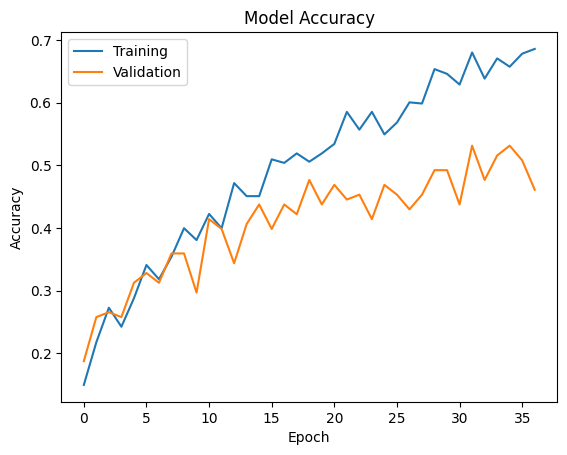

In [15]:
helpers.get_visualized_graph(
  plots=[model_history.history["acc"], model_history.history["val_acc"]],
  title="Model Accuracy",
  x_label="Epoch",
  y_label="Accuracy",
  legend=["Training", "Validation"]
).show()

### Loss Visualization

Visualizing loss data with Matplotlib graph

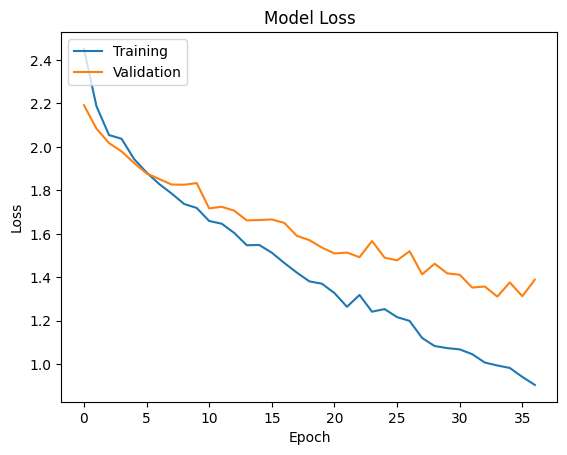

In [16]:
helpers.get_visualized_graph(
  plots=[model_history.history["loss"], model_history.history["val_loss"]],
  title="Model Loss",
  x_label="Epoch",
  y_label="Loss",
  legend=["Training", "Validation"]
).show()

### Export Dataframe From Model

Export dataframe to `.csv` file from the model history via Pandas library

In [17]:
model_history_dataframe = pd.DataFrame(model_history.history)
model_history_dataframe.to_csv(os.path.join("model/dance", "i3d-25e.csv"))

### Model Evaluation

Evaluating model with test dataset

In [18]:
model.evaluate(test_dataset_generator)

20/20 [==============================] - 40s 2s/step - loss: 1.5772 - acc: 0.4375


[1.5772069692611694, 0.4375]

### Populate Y Data

Populating Y's `prediction` and `test` data with test dataset

In [19]:
y_prediction_max, y_true = helpers.get_populated_y_data(
    batch_size=BATCH_SIZE,
    generator=test_dataset_generator,
    model=model
)

1/1 [==============================] - 0s 152ms/step


### Score Visualization

Visualizing some of calculated model score types, like `accuracy`, `precision`, `recall`, and `f1` score

In [20]:
score_accuracy, score_precision, score_recall, score_f1 = helpers.get_calculated_score(y_true, y_prediction_max)

print(f"Accuracy Score\t: {np.round(score_accuracy, 3)}")
print(f"Precision Score\t: {np.round(score_precision, 3)}")
print(f"Recall Score\t: {np.round(score_recall, 3)}")
print(f"F1 Score\t: {np.round(score_f1, 3)}")

Accuracy Score	: 0.431
Precision Score	: 0.572
Recall Score	: 0.426
F1 Score	: 0.406


### Classification Report Visualization

Visualizing classification report of test dataset

In [21]:
test_class_names = test_dataset_generator.classes

print(classification_report(
    y_true,
    y_prediction_max,
    target_names=test_class_names
))

                   precision    recall  f1-score   support

       Agem_Kanan       0.27      0.50      0.35        14
        Agem_Kiri       0.18      0.46      0.26        13
  Gandang_Gandang       1.00      0.06      0.12        16
           Malpal       0.57      0.53      0.55        15
            Nayog       0.15      0.15      0.15        13
     Nepuk_Kampuh       0.38      0.56      0.45        16
             Oyod       1.00      0.17      0.29        12
            Piles       0.67      0.13      0.22        15
          Seledet       1.00      1.00      1.00        16
Tapak_Sirang_Pada       0.71      0.86      0.77        14
        Ulap_Ulap       0.36      0.25      0.30        16

         accuracy                           0.43       160
        macro avg       0.57      0.43      0.41       160
     weighted avg       0.58      0.43      0.41       160



### Confusion Matrix Visualization

Visualizing confusion matrix with heatmap table

<Axes: >

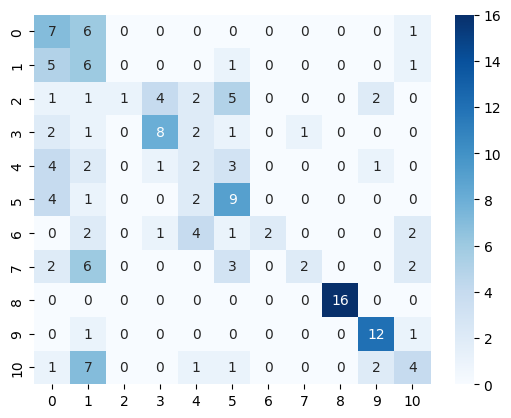

In [22]:
confusion_matrix_result = confusion_matrix(y_true, y_prediction_max)

sns.heatmap(
    confusion_matrix_result,
    annot=True,
    cmap="Blues"
)

### AUC Score Visualization

Visualization of AUC score calculated with FPR and TPR

In [23]:
fpr, tpr, _ = roc_curve(y_true, y_prediction_max, pos_label=6)
score_auc = auc(fpr, tpr)

print(f"AUC Score\t: {np.round(score_auc, 3)}")

AUC Score	: 0.582


### True/False Positive Rate Visualization

Visualizing `true`/`false` rate with Matplotlib graph calculated from FPR and TPR

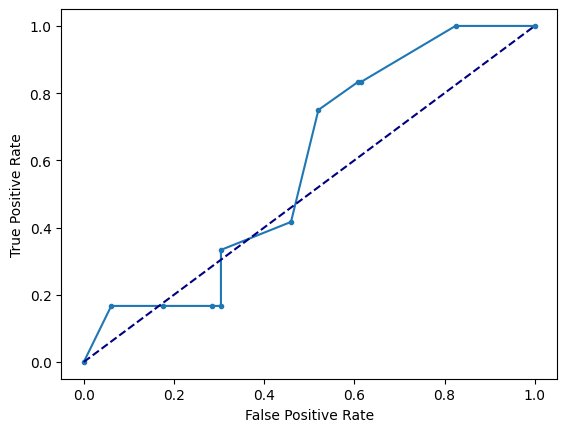

In [24]:
plt.plot(fpr, tpr, marker=".")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()

### Visualizing Checkpoint Model

Visualizing all the score/calculated score from the checkpoint model

In [25]:
# from tensorflow.keras.models import load_model

# checkpoint_model = load_model("checkpoint/i3d.h5")
# checkpoint_model.evaluate(test_dataset_generator)

### Populate Y Data

Populating checkpoint model Y's `prediction` and `test` data with test dataset

In [26]:
y_prediction_max, y_true = helpers.get_populated_y_data(
    batch_size=BATCH_SIZE,
    generator=test_dataset_generator,
    model=model
)

1/1 [==============================] - 0s 155ms/step


### Score Visualization

Visualizing some of calculated checkpoint model score types, like `accuracy`, `precision`, `recall`, and `f1` score

In [27]:
score_accuracy, score_precision, score_recall, score_f1 = helpers.get_calculated_score(y_true, y_prediction_max)

print(f"Accuracy Score\t: {np.round(score_accuracy, 3)}")
print(f"Precision Score\t: {np.round(score_precision, 3)}")
print(f"Recall Score\t: {np.round(score_recall, 3)}")
print(f"F1 Score\t: {np.round(score_f1, 3)}")

Accuracy Score	: 0.438
Precision Score	: 0.583
Recall Score	: 0.438
F1 Score	: 0.422


### Classification Report Visualization

Visualizing checkpoint model classification report of test dataset

In [28]:
test_class_names = test_dataset_generator.classes

print(classification_report(
    y_true,
    y_prediction_max,
    target_names=test_class_names
))

                   precision    recall  f1-score   support

       Agem_Kanan       0.35      0.47      0.40        17
        Agem_Kiri       0.21      0.53      0.30        15
  Gandang_Gandang       1.00      0.08      0.14        13
           Malpal       0.64      0.54      0.58        13
            Nayog       0.22      0.27      0.24        15
     Nepuk_Kampuh       0.36      0.64      0.46        14
             Oyod       1.00      0.13      0.24        15
            Piles       0.50      0.12      0.20        16
          Seledet       1.00      1.00      1.00        14
Tapak_Sirang_Pada       0.80      0.80      0.80        15
        Ulap_Ulap       0.33      0.23      0.27        13

         accuracy                           0.44       160
        macro avg       0.58      0.44      0.42       160
     weighted avg       0.58      0.44      0.42       160



### Confusion Matrix Visualization

Visualizing checkpoint model confusion matrix with heatmap table

<Axes: >

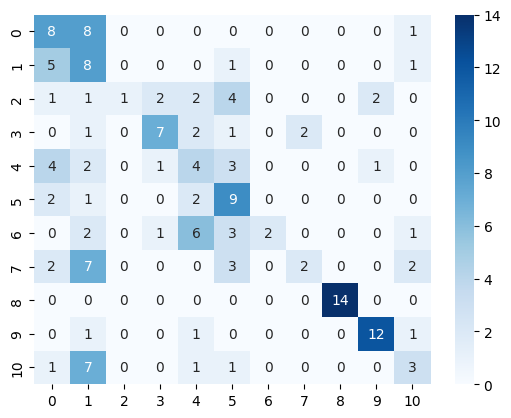

In [29]:
confusion_matrix_result = confusion_matrix(y_true, y_prediction_max)

sns.heatmap(
    confusion_matrix_result,
    annot=True,
    cmap="Blues"
)

### AUC Score Visualization

Visualization of checkpoint model AUC score calculated with FPR and TPR

In [30]:
fpr, tpr, _ = roc_curve(y_true, y_prediction_max, pos_label=6)
score_auc = auc(fpr, tpr)

print(f"AUC Score\t: {np.round(score_auc, 3)}")

AUC Score	: 0.566


### True/False Positive Rate Visualization

Visualizing checkpoint model `true`/`false` rate with Matplotlib graph calculated from FPR and TPR

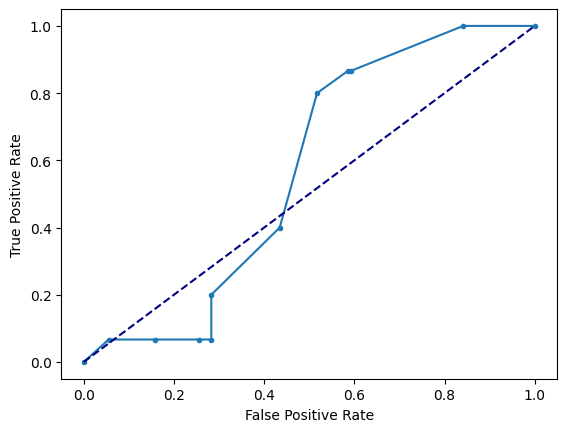

In [31]:
plt.plot(fpr, tpr, marker=".")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()